<a href="https://colab.research.google.com/github/abhilash1910/Deep_Reinforcement_Learning_Trading/blob/master/TimeSeries_S%26P/TD_Data/Time_series_S%26P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
import numpy as np
import pandas as pd
import datetime 
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#data from "TS_Data" folder inside https://github.com/abhilash1910/Deep_Reinforcement_Learning_Trading
df_sp500 = pd.read_csv('SP500.csv')
df_sp500.head(10)

,DATE,SP500
0,2010-06-28,1074.57
1,2010-06-29,1041.24
2,2010-06-30,1030.71
3,2010-07-01,1027.37
4,2010-07-02,1022.58
5,2010-07-05,.
6,2010-07-06,1028.06
7,2010-07-07,1060.27
8,2010-07-08,1070.25
9,2010-07-09,1077.96


In [ ]:
df_sp500[df_sp500['SP500'] == '.'].shape

(92, 2)

In [ ]:
df_sp500['SP500'] = pd.to_numeric(df_sp500['SP500'], errors='coerce')
df_sp500['DATE'] = pd.to_datetime(df_sp500['DATE']).dt.date

In [ ]:
df_sp500.dropna(inplace=True)

In [ ]:
df_sp500.set_index('DATE', inplace=True)

In [ ]:
df_sp500.dtypes

SP500    float64
dtype: object

In [ ]:
df_sp500.head()

,SP500
DATE,
2010-06-28,1074.57
2010-06-29,1041.24
2010-06-30,1030.71
2010-07-01,1027.37
2010-07-02,1022.58


In [ ]:
df_sample = df_sp500[(df_sp500.index > datetime.date(2015,1,1)) 
# & (df_sp500['DATE']<datetime.date(2016,3,1))]  
]

# EDA

In [ ]:
roll_avg_10 = df_sample.SP500.rolling(window=10).mean()
roll_avg_30 = df_sample.SP500.rolling(window=30).mean()
roll_avg_70 = df_sample.SP500.rolling(window=70).mean()

[Text(0, 0.5, 'S&P 500'), Text(0.5, 0, 'Date')]

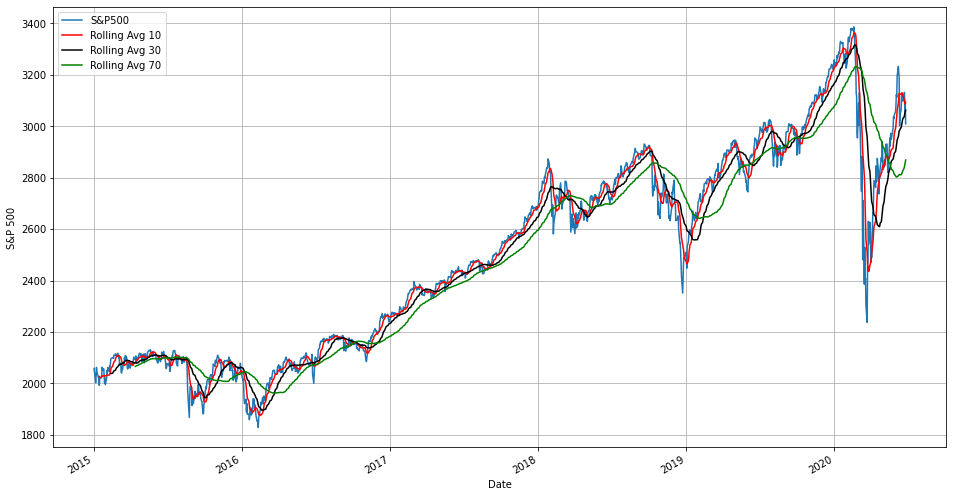

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
fig.autofmt_xdate()
ax.plot(df_sample.SP500, label='S&P500', color='tab:blue')
ax.plot(roll_avg_10, label='Rolling Avg 10', color='r')
ax.plot(roll_avg_30, label='Rolling Avg 30', color='k')
ax.plot(roll_avg_70, label='Rolling Avg 70', color='g')
ax.legend()
ax.grid()
ax.set(xlabel='Date',ylabel='S&P 500')

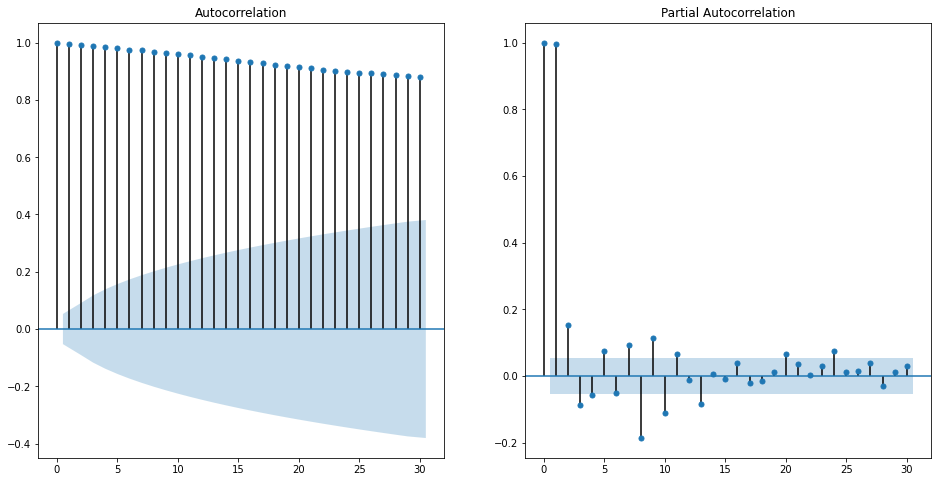

In [ ]:
import statsmodels.api as sm

# Graph data
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

fig = sm.graphics.tsa.plot_acf(df_sample.iloc[1:]['SP500'], lags=30, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df_sample.iloc[1:]['SP500'], lags=30, ax=axes[1])

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))

In [ ]:
check_stationarity(df_sample.SP500)

The test statistic: -1.508554
p-value: 0.529276
Critical Values:
1%: -3.435
5%: -2.864
10%: -2.568


The value of test statistics is more than 5% critical value and p-value is also 
more than 0.05 so we can not accept Alternate Hypothesis at this significance level. The time series is non stationary.

In [ ]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [ ]:
df_diff =  difference(df_sample.SP500, 1)

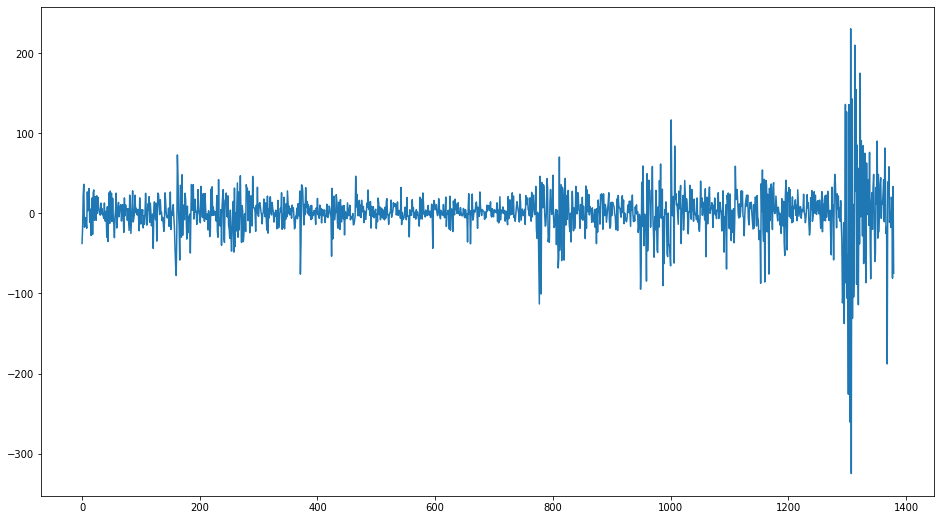

In [ ]:
df_diff.plot(figsize=(16, 9))

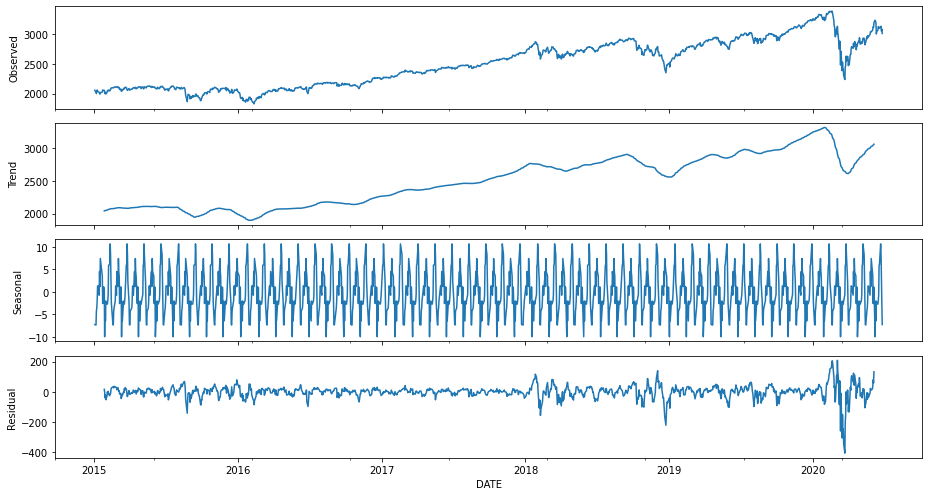

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_sample['SP500'], model='additive', freq=30)
plt.rcParams["figure.figsize"] = [13, 7]
fig = decomposition.plot()

In [ ]:
# move to top 
df_sample = df_sample.assign(y_log=np.log(df_sample.SP500))
df_sample.head()

,SP500,y_log
DATE,,
2015-01-02,2058.20,7.629587
2015-01-05,2020.58,7.611140
2015-01-06,2002.61,7.602207
2015-01-07,2025.90,7.613769
2015-01-08,2062.14,7.631500


# ARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_sample.y_log, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.y_log   No. Observations:                 1380
Model:                 ARIMA(1, 1, 2)   Log Likelihood                4191.820
Method:                       css-mle   S.D. of innovations              0.012
Date:                Tue, 30 Jun 2020   AIC                          -8373.639
Time:                        17:55:44   BIC                          -8347.490
Sample:                             1   HQIC                         -8363.857
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      1.096      0.273      -0.000       0.001
ar.L1.D.y_log    -0.9018      0.027    -33.180      0.000      -0.955      -0.849
ma.L1.D.y_log     0.7571      0.033     

In [ ]:
model = ARIMA(df_sample.y_log, order=(3,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.y_log   No. Observations:                 1379
Model:                 ARIMA(3, 2, 1)   Log Likelihood                4185.768
Method:                       css-mle   S.D. of innovations              0.012
Date:                Tue, 30 Jun 2020   AIC                          -8359.536
Time:                        17:55:45   BIC                          -8328.162
Sample:                             2   HQIC                         -8347.799
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.128e-08   8.74e-07      0.059      0.953   -1.66e-06    1.76e-06
ar.L1.D2.y_log    -0.2041      0.027     -7.566      0.000      -0.257      -0.151
ar.L2.D2.y_log     0.1256      0.027

In [ ]:
import itertools

p = [0, 1, 2, 4, 6, 8, 10]
d = range(0, 3)
q = range(0, 3)

pdq = list(itertools.product(p, d, q))

In [ ]:
for param in pdq:
  try:
    model = ARIMA(df_sample.y_log, order=param)
    results = model.fit()
    print('ARIMA{} - AIC:{}'.format(param, results.aic))
  except:
    continue

ARIMA(0, 0, 0) - AIC:-1251.4728471765625
ARIMA(0, 0, 1) - AIC:-3051.213570750434
ARIMA(0, 0, 2) - AIC:-4289.552080920199
ARIMA(0, 1, 0) - AIC:-8304.524074973964
ARIMA(0, 1, 1) - AIC:-8354.938664488756
ARIMA(0, 1, 2) - AIC:-8380.47467981487
ARIMA(0, 2, 0) - AIC:-7077.825300224489
ARIMA(0, 2, 1) - AIC:-8288.276839428765
ARIMA(1, 0, 0) - AIC:-8304.27741144136
ARIMA(1, 0, 1) - AIC:-8353.503769720539
ARIMA(1, 0, 2) - AIC:-8379.861747051378
ARIMA(1, 1, 0) - AIC:-8367.065685151447
ARIMA(1, 1, 1) - AIC:-8371.98080227958
ARIMA(1, 1, 2) - AIC:-8373.639217707734
ARIMA(1, 2, 0) - AIC:-7811.583707753442
ARIMA(1, 2, 1) - AIC:-8350.386481489753
ARIMA(1, 2, 2) - AIC:-8342.345418620946
ARIMA(2, 0, 0) - AIC:-8365.599763045027
ARIMA(2, 0, 1) - AIC:-8370.70050097593
ARIMA(2, 0, 2) - AIC:-8372.135416335193
ARIMA(2, 1, 0) - AIC:-8377.060069564293
ARIMA(2, 1, 1) - AIC:-8399.226871646211
ARIMA(2, 1, 2) - AIC:-8479.213788938401
ARIMA(2, 2, 0) - AIC:-8005.68927073423
ARIMA(2, 2, 1) - AIC:-8360.567771809083
ARIM

Best parameters: ARIMA(8, 0, 2) - AIC:-8485.567422326247

In [ ]:
best_order = (8, 0, 2)
model = ARIMA(df_sample.y_log, order=best_order)
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  y_log   No. Observations:                 1381
Model:                     ARMA(8, 2)   Log Likelihood                4254.784
Method:                       css-mle   S.D. of innovations              0.011
Date:                Tue, 30 Jun 2020   AIC                          -8485.567
Time:                        17:59:22   BIC                          -8422.801
Sample:                             0   HQIC                         -8462.088
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.8166      0.107     72.747      0.000       7.606       8.027
ar.L1.y_log    -0.2908      0.192     -1.517      0.129      -0.667       0.085
ar.L2.y_log     0.7547      0.048     15.578    

[]

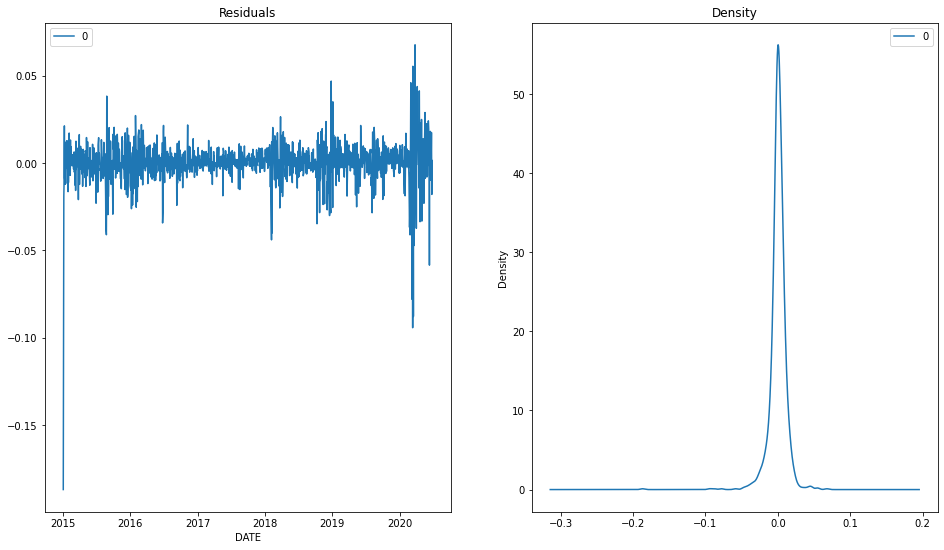

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(16, 9))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.plot()

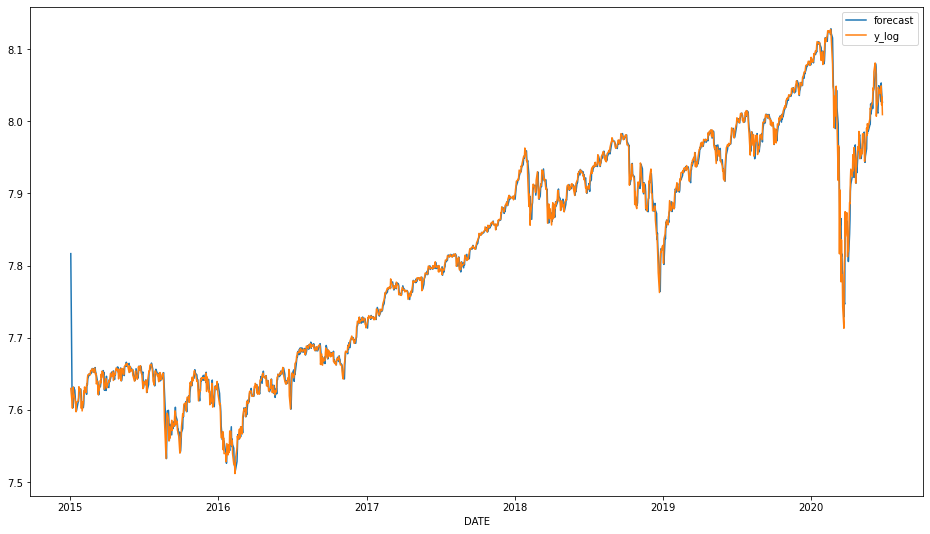

In [ ]:
from statsmodels.graphics.gofplots import qqplot_2samples
n, m = 16, 9
with plt.rc_context():
  plt.rc("figure", figsize=(n,m))
  model_fit.plot_predict(dynamic=False)

In [ ]:
TRAIN_END_INDEX = 1361
# Create Training and Test
train = df_sample.y_log[:TRAIN_END_INDEX]
test = df_sample.y_log[TRAIN_END_INDEX:]

In [ ]:
# Build Model
model = ARIMA(train, order=best_order)  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(20, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)


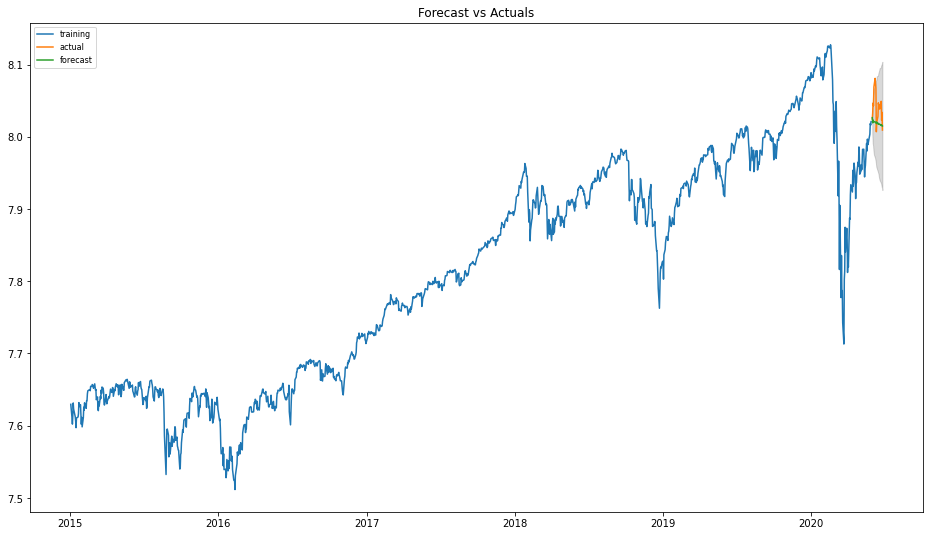

In [ ]:
# Plot
plt.figure(figsize=(16, 9))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

In [ ]:
fc_series.index

Index([2020-06-01, 2020-06-02, 2020-06-03, 2020-06-04, 2020-06-05, 2020-06-08,
       2020-06-09, 2020-06-10, 2020-06-11, 2020-06-12, 2020-06-15, 2020-06-16,
       2020-06-17, 2020-06-18, 2020-06-19, 2020-06-22, 2020-06-23, 2020-06-24,
       2020-06-25, 2020-06-26],
      dtype='object', name='DATE')

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f2d71bd9630>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f2d71beebe0>)

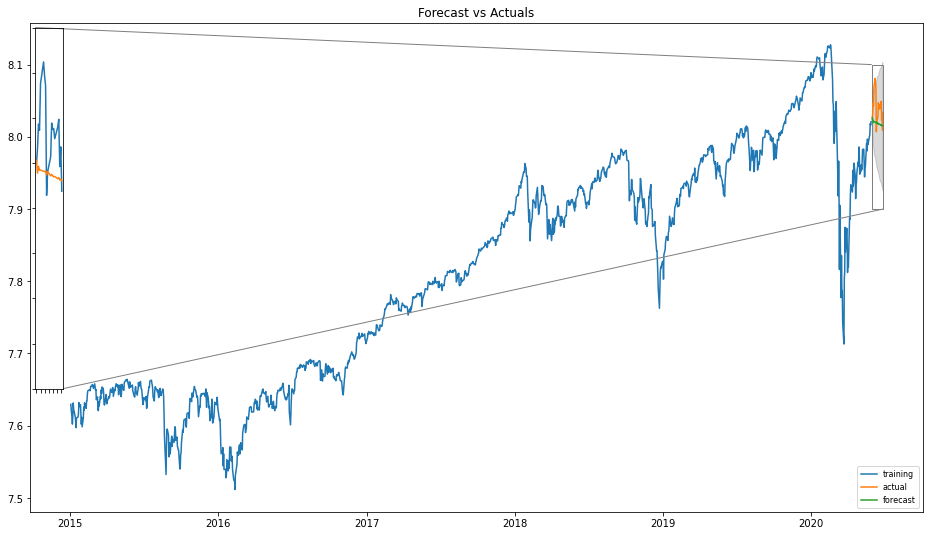

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(train, label='training')
ax.plot(test, label='actual')
ax.plot(fc_series, label='forecast')
ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax.set_title('Forecast vs Actuals')
ax.legend(loc='lower right', fontsize=8)

axins = zoomed_inset_axes(ax, 2.5, loc=2) # zoom-factor: 2.5, location: upper-left
# axins.plot(train)
axins.plot(test)
axins.plot(fc_series)

# # x1, x2, y1, y2 = '2020-06-01', '2020-06-26', 2800, 3300 # specify the limits
x1, x2, y1, y2 = '2020-05-01', '2020-06-26', 7.9, 8.1 # specify the limits
# axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
plt.yticks(visible=False)
plt.xticks(visible=False)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

In [ ]:
# y_true cannot be zero will cause div by zero error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('ARIMA model mse :', mean_squared_error(np.exp(test), np.exp(fc_series)))
print('ARIMA model mae :', mean_absolute_error(np.exp(test), np.exp(fc_series)))
print('ARIMA model mape :', mean_absolute_percentage_error(np.exp(test), np.exp(fc_series)))

ARIMA model mse : 8373.648947333628
ARIMA model mae : 75.04432417329758
ARIMA model mape : 2.3843895896239635


# SARIMAX

In [ ]:
# p_values = [0, 1, 2, 4, 6, 8, 10]
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df_sample.y_log,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:9592.66769121692
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:7684.807638467787
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-5148.817955840601
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-5092.821269253875
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-5164.531728639009
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-5158.009874422289
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-5097.319373717808
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-5103.687850466811
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:7684.616298678026
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5793.680125719456
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-6213.711919458961
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-6178.220518388822
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-6229.826659521026
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-6252.456315601492
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-6176.691802009218
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-6239.364130605947
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-8301.16207044468
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-8232.03784161632

Best SARIMAX params: ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-8350.051909976024



In [ ]:
# Fitting the data to ARIMA model 
model_sarima = SARIMAX(df_sample.y_log,
                                order=(1, 0, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_sarima = model_sarima.fit()
print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.61e-05   2.77e+04      0.000       1.000       1.000
ma.L1         -0.1952      0.010    -19.248      0.000      -0.215      -0.175
sigma2         0.0001   1.73e-06     78.980      0.000       0.000       0.000


[]

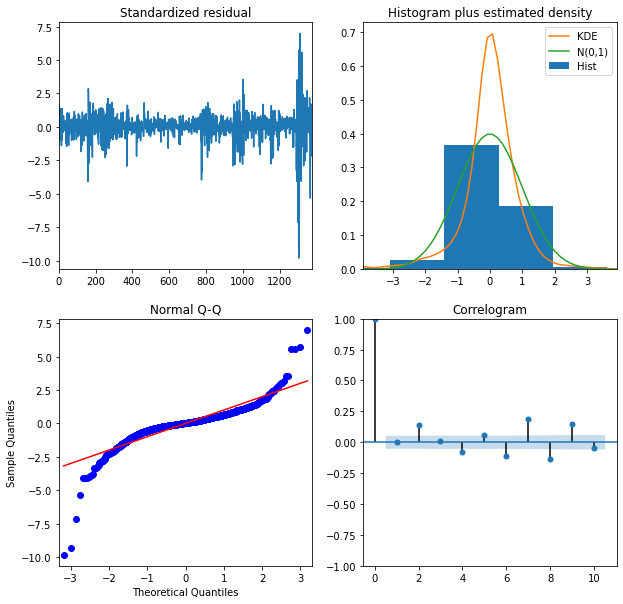

In [ ]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.plot()

In [ ]:
# Build Model
model = SARIMAX(train,
                order=(1, 0, 1),
                seasonal_order=(0, 0, 0, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)  
# model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

In [ ]:
# Forecast
fc = fitted.forecast(20)

In [ ]:

# Make as pandas series
fc_series = pd.Series(fc.values, index=test.index)

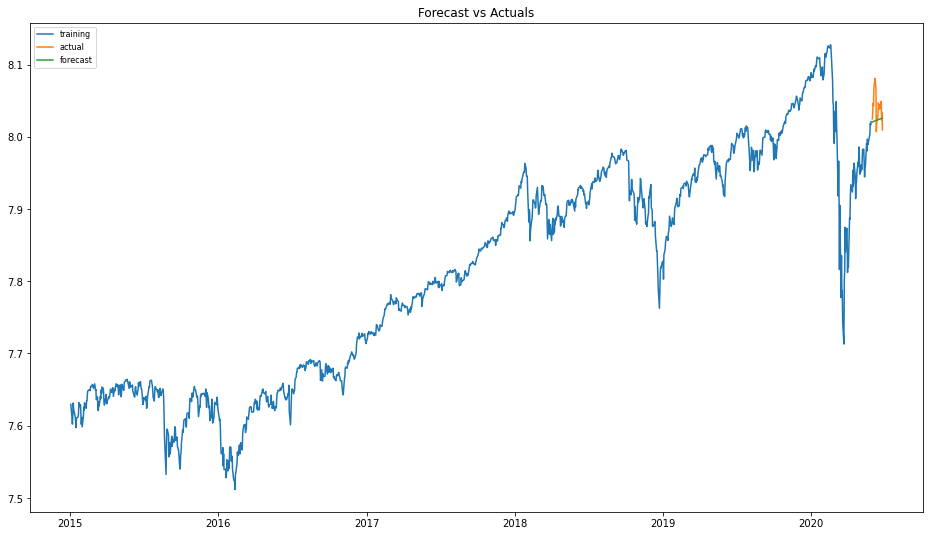

In [ ]:
# Plot
plt.figure(figsize=(16, 9))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f2d703b1400>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f2d703b1f98>)

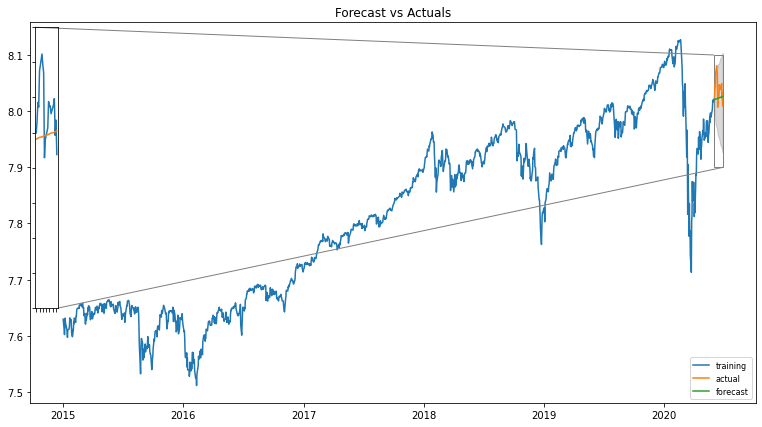

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 

fig, ax = plt.subplots()
ax.plot(train, label='training')
ax.plot(test, label='actual')
ax.plot(fc_series, label='forecast')
ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax.set_title('Forecast vs Actuals')
ax.legend(loc='lower right', fontsize=8)

axins = zoomed_inset_axes(ax, 2.5, loc=2) # zoom-factor: 2.5, location: upper-left
axins.plot(test)
axins.plot(fc_series)

# x1, x2, y1, y2 = 2550, 2620, 2800, 3300 # specify the limits
x1, x2, y1, y2 = 2550, 2620, 7.9, 8.1 # specify the limits
# axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
plt.yticks(visible=False)
plt.xticks(visible=False)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

In [ ]:
print('SARIMAX model MSE :', mean_squared_error(np.exp(test), np.exp(fc_series)))
print('SARIMAX model MAE :', mean_absolute_error(np.exp(test), np.exp(fc_series)))
print('SARIMAX model MAPE :', mean_absolute_percentage_error(np.exp(test), np.exp(fc_series)))

SARIMAX model MSE : 7160.399849765299
SARIMAX model MAE : 67.83487405471803
SARIMAX model MAPE : 2.1557077179276494


# PROPHET

In [ ]:
from fbprophet import Prophet

In [ ]:
df_sample.head()

,SP500,y_log
DATE,,
2015-01-02,2058.20,7.629587
2015-01-05,2020.58,7.611140
2015-01-06,2002.61,7.602207
2015-01-07,2025.90,7.613769
2015-01-08,2062.14,7.631500


In [ ]:
df_prophet = df_sample.copy()

In [ ]:
df_prophet['DATE'] = df_sample.index
df_prophet.head()

,SP500,y_log,DATE
DATE,,,
2015-01-02,2058.20,7.629587,2015-01-02
2015-01-05,2020.58,7.611140,2015-01-05
2015-01-06,2002.61,7.602207,2015-01-06
2015-01-07,2025.90,7.613769,2015-01-07
2015-01-08,2062.14,7.631500,2015-01-08


In [ ]:
df_prophet = df_prophet.rename(columns={'SP500':'y', 'DATE':'ds'})
df_prophet.head(2)

,y,y_log,ds
DATE,,,
2015-01-02,2058.20,7.629587,2015-01-02
2015-01-05,2020.58,7.611140,2015-01-05


In [ ]:
TRAIN_END_INDEX = 1361

# Create Training and Test df
train = df_prophet[:TRAIN_END_INDEX]
test = df_prophet[TRAIN_END_INDEX:]

In [ ]:
model = Prophet(daily_seasonality=True) #instantiate Prophet
model.fit(train); #fit the model with your dataframe

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
future_data = model.make_future_dataframe(periods=20)

In [ ]:
forecast_data = model.predict(future_data)

In [ ]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1376,2020-06-14,2995.725552,2858.971432,3116.115988
1377,2020-06-15,2993.618216,2871.851409,3123.648285
1378,2020-06-16,2996.411623,2871.374740,3119.556263
1379,2020-06-17,2994.592422,2864.974004,3114.627420
1380,2020-06-18,2995.386109,2879.720857,3109.125668


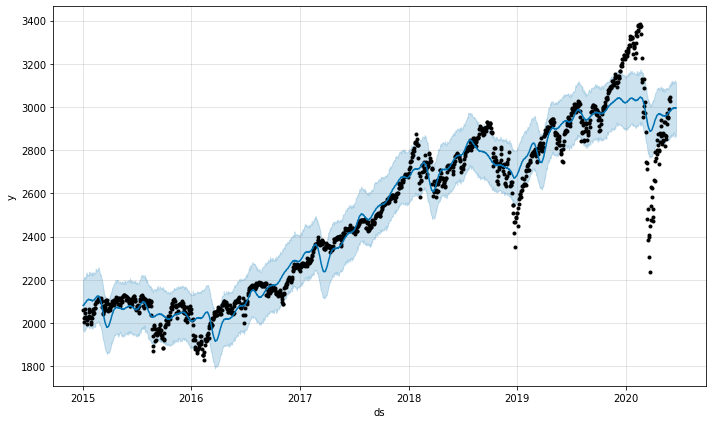

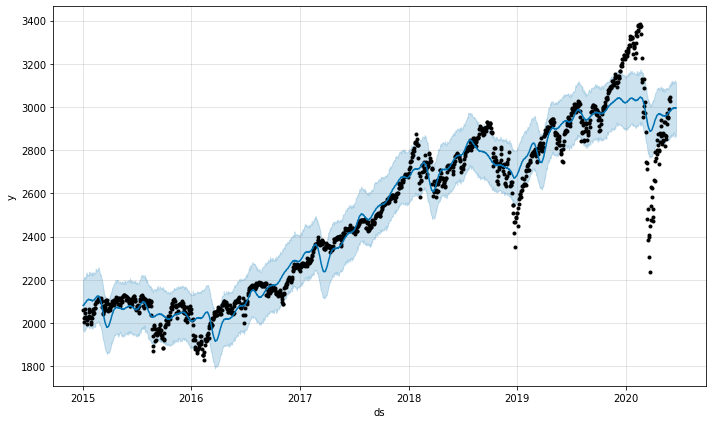

In [ ]:
model.plot(forecast_data)

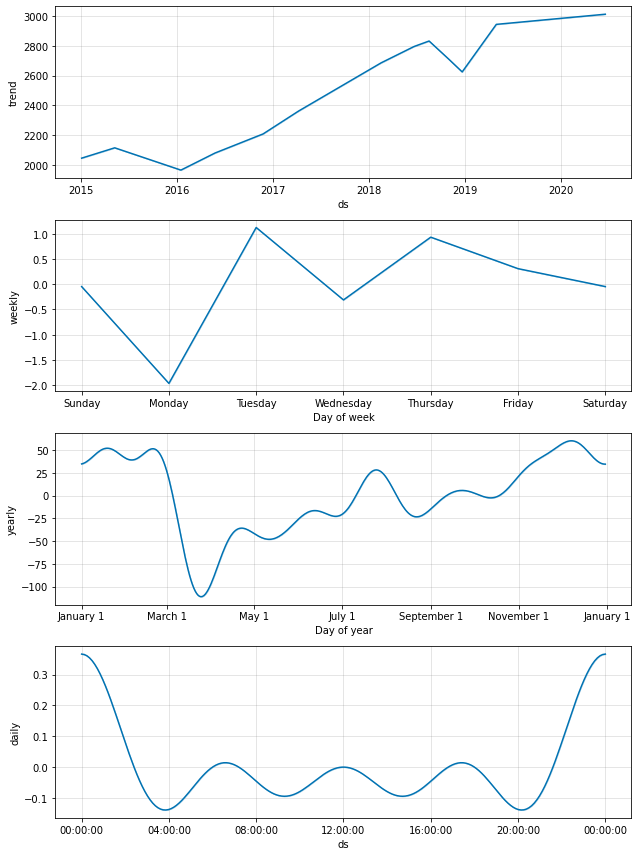

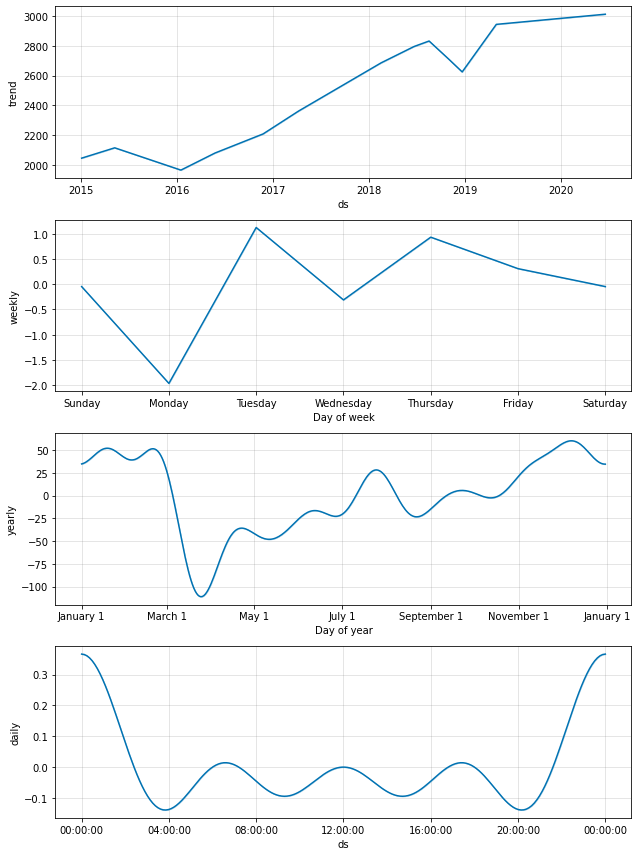

In [ ]:
model.plot_components(forecast_data)

In [ ]:
forecast = forecast_data.yhat[-20:]

In [ ]:
test['y'][:5]

DATE
2020-06-01    3055.73
2020-06-02    3080.82
2020-06-03    3122.87
2020-06-04    3112.35
2020-06-05    3193.93
Name: y, dtype: float64

In [ ]:
print('Prophet model MAE :', mean_squared_error(test['y'], forecast))
print('Prophet model MSE :', mean_absolute_error(test['y'], forecast))
print('Prophet model MAPE :', mean_absolute_percentage_error(test['y'], forecast))

Prophet model MAE : 17202.67839237924
Prophet model MSE : 115.50408153919875
Prophet model MAPE : 3.6792422446853497


# LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
scaled_df = df_sample.SP500.values.reshape(df_sample.SP500.shape[0], 1)
scaled_df = scaler.fit_transform(scaled_df)

In [ ]:
scaled_df.shape

(1381, 1)

In [ ]:
def preprocess(df, look_back):
    X, y = [], []
    for i in range(look_back, len(df)):
        X.append(df[i-look_back:i,0])
        y.append(df[i,0])
    return np.array(X),np.array(y)

In [ ]:
look_back = 60
X, y = preprocess(scaled_df, look_back)

In [ ]:
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

1188
133
1188
133


In [ ]:
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, LSTM


Using TensorFlow backend.


In [ ]:
#Build the model
model1 = Sequential()
model1.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
model1.add(Dense(1))
model1.compile(optimizer='adam',loss='mse')

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

In [ ]:
#Fit model with history to check for overfitting
history1 = model1.fit(X_train,y_train,epochs=40, validation_data=(X_test,y_test),shuffle=False)

Train on 1188 samples, validate on 133 samples
Epoch 1/40
1188/1188 [==============================] - 2s 1ms/step - loss: 0.0033 - val_loss: 0.0104
Epoch 2/40
1188/1188 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0103
Epoch 3/40
1188/1188 [==============================] - 1s 1ms/step - loss: 0.0049 - val_loss: 0.0059
Epoch 4/40
1188/1188 [==============================] - 1s 1ms/step - loss: 6.3039e-04 - val_loss: 0.0065
Epoch 5/40
1188/1188 [==============================] - 1s 1ms/step - loss: 5.8396e-04 - val_loss: 0.0063
Epoch 6/40
1188/1188 [==============================] - 1s 1ms/step - loss: 5.5111e-04 - val_loss: 0.0062
Epoch 7/40
1188/1188 [==============================] - 1s 1ms/step - loss: 5.4793e-04 - val_loss: 0.0060
Epoch 8/40
1188/1188 [==============================] - 1s 1ms/step - loss: 5.2134e-04 - val_loss: 0.0058
Epoch 9/40
1188/1188 [==============================] - 1s 1ms/step - loss: 5.2238e-04 - val_loss: 0.0056
Epoch 10/40

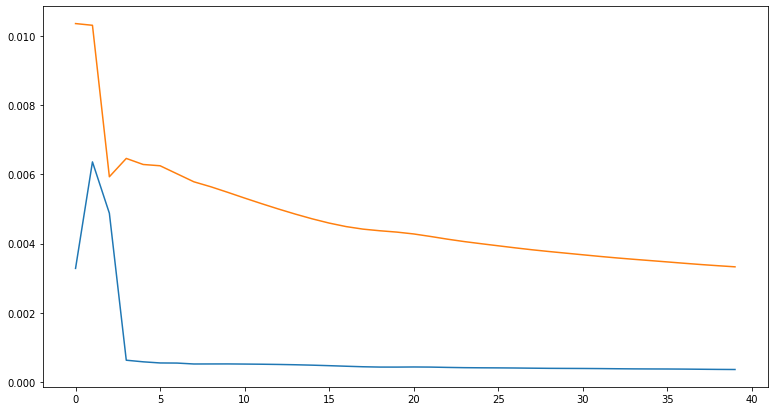

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

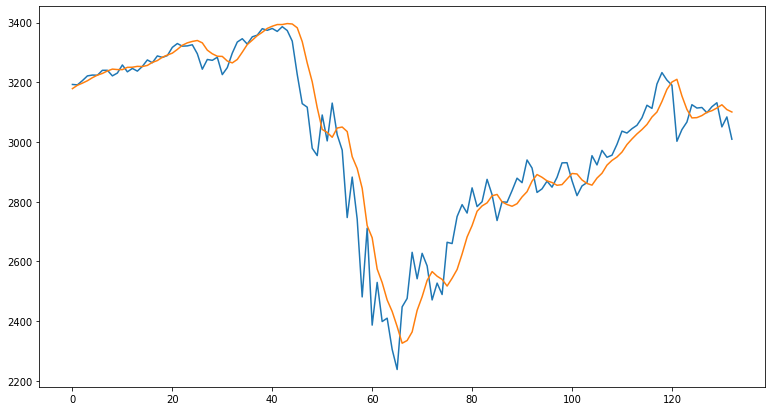

In [ ]:
Xt = model1.predict(X_test)
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(Xt))

In [ ]:
# act = []
# pred = []
# for i in range(X_test.shape[0]):
#   # i=274
#   Xt = model1.predict(X_test[i].reshape(1, 60,1))
#   # print('predicted:{0}, actual:{1}'.format(scaler.inverse_transform(Xt),scaler.inverse_transform(y_test[i].reshape(-1,1))))
#   pred.append(scaler.inverse_transform(Xt))
#   act.append(scaler.inverse_transform(y_test[i].reshape(-1,1)))

## Stacked LSTM

In [ ]:
#Build the model
model2 = Sequential()
model2.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True))
model2.add(LSTM(64, return_sequences=True))
model2.add(LSTM(64))
model2.add(Dense(1))
model2.compile(optimizer='adam',loss='mse')

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 64)            33024     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = model2.fit(X_train,y_train,epochs=100, validation_data=(X_test,y_test), shuffle=False)

Train on 1188 samples, validate on 133 samples
Epoch 1/100
1188/1188 [==============================] - 5s 4ms/step - loss: 0.0048 - val_loss: 0.0166
Epoch 2/100
1188/1188 [==============================] - 4s 3ms/step - loss: 0.0098 - val_loss: 0.0161
Epoch 3/100
1188/1188 [==============================] - 4s 3ms/step - loss: 0.0154 - val_loss: 0.0315
Epoch 4/100
1188/1188 [==============================] - 4s 3ms/step - loss: 0.0129 - val_loss: 0.0235
Epoch 5/100
1188/1188 [==============================] - 4s 3ms/step - loss: 0.0028 - val_loss: 0.0129
Epoch 6/100
1188/1188 [==============================] - 4s 3ms/step - loss: 0.0024 - val_loss: 0.0125
Epoch 7/100
1188/1188 [==============================] - 4s 3ms/step - loss: 0.0013 - val_loss: 0.0128
Epoch 8/100
1188/1188 [==============================] - 4s 3ms/step - loss: 0.0019 - val_loss: 0.0124
Epoch 9/100
1188/1188 [==============================] - 4s 3ms/step - loss: 0.0010 - val_loss: 0.0119
Epoch 10/100
1188/1188 [==

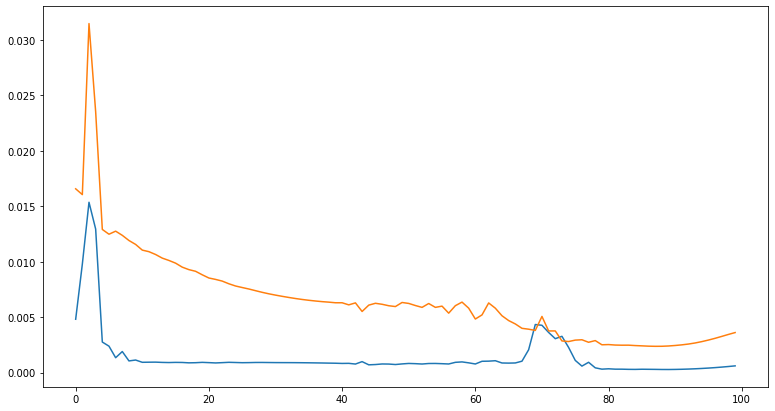

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

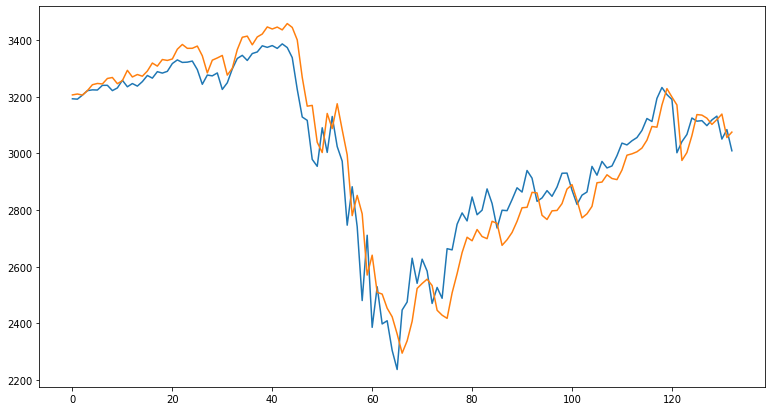

In [ ]:
Xt2 = model2.predict(X_test)
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(Xt2))

In [ ]:
act2 = []
pred2 = []
for i in range(X_test.shape[0]):
  # i=274
  Xt2 = model2.predict(X_test[i].reshape(1, 60,1))
  # print('predicted:{0}, actual:{1}'.format(scaler.inverse_transform(Xt),scaler.inverse_transform(y_test[i].reshape(-1,1))))
  pred2.append(scaler.inverse_transform(Xt2))
  act2.append(scaler.inverse_transform(y_test[i].reshape(-1,1)))

In [ ]:
result_df2 = pd.DataFrame({'pred':list(np.reshape(pred2, (-1))),'act':list(np.reshape(act2, (-1)))})
result_df2.head()

,pred,act
0,3206.176025,3192.52
1,3209.368408,3191.14
2,3205.572754,3205.37
3,3221.192871,3221.22
4,3242.097900,3224.01


In [ ]:
# test2 = np.exp(result_df2['act'])
# forecast2 = np.exp(result_df2['pred'])

test2 = result_df2['act']
forecast2 = result_df2['pred']

In [ ]:
print('LSTM model MSE :', mean_squared_error(test2, forecast2))
print('LSTM model MAE :', mean_absolute_error(test2, forecast2))
print('LSTM model MAPE :', mean_absolute_percentage_error(test2, forecast2))

LSTM model MSE : 8746.264880343393
LSTM model MAE : 73.64643811677631
LSTM model MAPE : 2.5585887766466593


## CNN LSTM

In [ ]:
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
X_train = X_train.reshape((X_train.shape[0],1, 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

(1188, 1, 1, 60) (133, 1, 1, 60)


In [ ]:
model3 = Sequential()
model3.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 1, 60)))
model3.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))
model3.add(TimeDistributed(Flatten()))
model3.add(LSTM(64, activation='relu'))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')

model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 1, 64)       3904      
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 36,993
Trainable params: 36,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history3 = model3.fit(X_train,y_train,epochs=100, validation_data=(X_test,y_test), shuffle=False)

Train on 1188 samples, validate on 133 samples
Epoch 1/100
1188/1188 [==============================] - 0s 403us/step - loss: 0.0055 - val_loss: 0.0406
Epoch 2/100
1188/1188 [==============================] - 0s 74us/step - loss: 0.0026 - val_loss: 0.0355
Epoch 3/100
1188/1188 [==============================] - 0s 78us/step - loss: 0.0025 - val_loss: 0.0259
Epoch 4/100
1188/1188 [==============================] - 0s 75us/step - loss: 0.0026 - val_loss: 0.0261
Epoch 5/100
1188/1188 [==============================] - 0s 75us/step - loss: 0.0027 - val_loss: 0.0270
Epoch 6/100
1188/1188 [==============================] - 0s 74us/step - loss: 0.0023 - val_loss: 0.0232
Epoch 7/100
1188/1188 [==============================] - 0s 73us/step - loss: 0.0017 - val_loss: 0.0188
Epoch 8/100
1188/1188 [==============================] - 0s 73us/step - loss: 0.0014 - val_loss: 0.0165
Epoch 9/100
1188/1188 [==============================] - 0s 72us/step - loss: 0.0015 - val_loss: 0.0154
Epoch 10/100
118

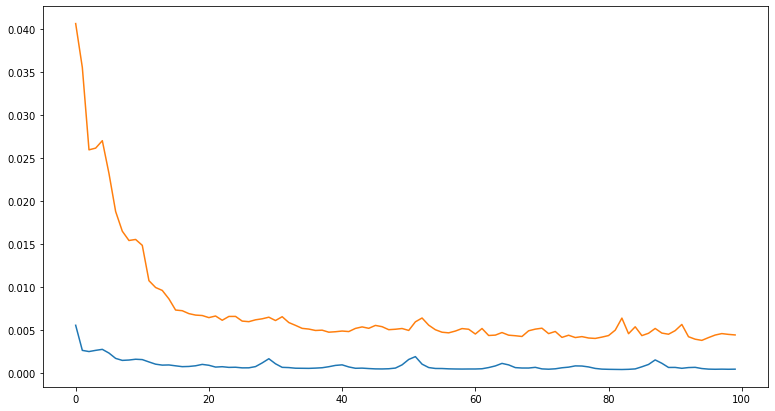

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])

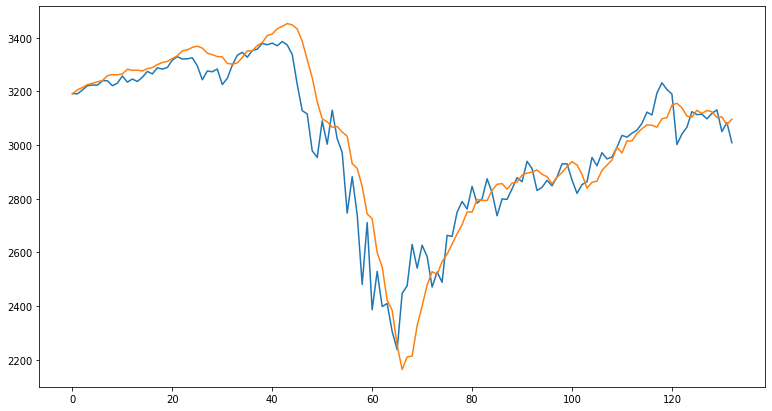

In [ ]:
Xt3 = model3.predict(X_test)
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(Xt3))

In [ ]:
act3 = []
pred3 = []
for i in range(X_test.shape[0]):
  # i=274
  Xt3 = model3.predict(X_test[i].reshape(1, 1, 1, 60))
  # print('predicted:{0}, actual:{1}'.format(scaler.inverse_transform(Xt),scaler.inverse_transform(y_test[i].reshape(-1,1))))
  pred3.append(scaler.inverse_transform(Xt3))
  act3.append(scaler.inverse_transform(y_test[i].reshape(-1,1)))

In [ ]:
result_df3 = pd.DataFrame({'pred':list(np.reshape(pred3, (-1))),'act':list(np.reshape(act3, (-1)))})
result_df3.head(2)

,pred,act
0,3190.428955,3192.52
1,3205.894287,3191.14


In [ ]:
test3 = result_df3['act']
forecast3 = result_df3['pred']

In [ ]:
print('LSTM model MSE :', mean_squared_error(test3, forecast3))
print('LSTM model MAE :', mean_absolute_error(test3, forecast3))
print('LSTM model MAPE :', mean_absolute_percentage_error(test3, forecast3))

LSTM model MSE : 10689.376926885327
LSTM model MAE : 66.30246761924344
LSTM model MAPE : 2.3295964655884216
